**TODO**
- Create new samples to test

### Required libraries

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import pickle
import matplotlib.pyplot as plt
#from community import best_partition
from collections import Counter


### Load Data

In [3]:
def save_file(filename,var):
    # save users to pickle
    with open(filename, 'wb') as f:
        pickle.dump(var, f)

In [4]:
def read_file(filename):
    # load users from pickle
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [4]:
users = read_file('./data/users.pickle')

In [5]:
business = read_file('./data/business.pickle')


In [6]:
tip = read_file('./data/tip.pickle')


In [7]:
checkin = read_file('./data/checkin.pickle')

In [8]:
reviews = read_file('./data/reviews.pickle')


In [9]:
users.shape


(1987897, 22)

In [4]:
# Define the initial set of users randomly
initial_users = ['qVc8ODYU5SZjKXVBgXdI7w', 'j14WgRoU_-2ZE1aw1dXrJg']

In [35]:
# # choose first user random an then choose the second user from the friends of the first user
# initial_users = [random.choice(list(users['user_id']))]

# while len(initial_users) < 2:
#  
#     if len(users[users['user_id'] == initial_users[0]]['friends']) > 0:
#         # add frined 
#         initial_users.append(random.choice(users[users['user_id'] == initial_users[0]]['friends'].values[0].split(', ')))
#     else:
#         # if the user has no friends, choose another user
#         initial_users.append(random.choice(list(users['user_id'])))
# print(initial_users)

['oV2bQphwoweVY1egDn3MYQ', 'EnvYZmBjvfMsIYOMEwuWOw']


In [11]:
# Define the maximum sample_users size
max_sample_size = 1000

# Initialize the sample_users with the initial set of users
sample_users = users[users['user_id'].isin(initial_users)]

# Initialize the set of users to expand
users_to_expand = set(initial_users)

while len(sample_users) < max_sample_size and len(users_to_expand) > 0:
    # Get the next user to expand
    user_to_expand = users_to_expand.pop()

    # Get the friends of the user
friends = users[users['user_id'] == user_to_expand]['friends'].iloc[0]

# Check if the friends value is None
if friends is None:
    # If friends is None, set it to an empty list
    friends = []
else:
    # If friends is not None, split it into a list
    friends = friends.split(', ')

    # Add the friends to the sample_users
    sample_users = pd.concat([sample_users, users[users['user_id'].isin(friends)]])

    # Add the friends to the set of users to expand
    users_to_expand.update(friends)

# Limit the sample_users size to the maximum sample_users size
sample_users = sample_users.iloc[:max_sample_size]


In [12]:
print('Sample size: {}'.format(len(sample_users)))

# remove users that are not in the sample_users from friends in sample_users
sample_users['friends'] = sample_users['friends'].apply(lambda x: [f for f in x.split(', ') if f in sample_users['user_id'].values])
sample_users.head()


Sample size: 1000


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"[om5ZiponkpRqUNa3pVPiRg, 4OH-U9PWeBa9HOPM4f3-z...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","[BW_Lpb14P7CTQwHlaek0_w, 1_cezAbuZSyLR1-FL6V91...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
38,QJI9OSEn6ujRCtrX06vs1w,J,1982,2007-03-19 18:15:32,14004,6466,9879,2010,"[ya3mbvTaymecfrTc08SxhQ, CNdJaOdUjLIceVxhWcMNR...",316,...,98,156,52,68,786,3674,2093,2093,562,1509
55,2l0O1EI1m0yWjFo2zSt71w,Shiho,2837,2005-07-02 01:59:55,19237,9542,15235,"2006,2007,2008,2009,2010,2011","[9GhiQOLaM6ZGrrFG-SppwQ, d67zTET_2IuVoWcUU0aWa...",492,...,108,85,79,40,350,742,1070,1070,403,258
57,V6PeLHJ8D1C7utl4HzjBmg,Jay,371,2010-01-26 21:04:52,2933,1129,1861,"2012,2013,2014,2015,2016,2017","[-IgKkE8JvYNWeGu8ze4P8Q, 9w32ooe10bil7oIr5ycQA...",112,...,14,45,0,3,157,432,535,535,198,74


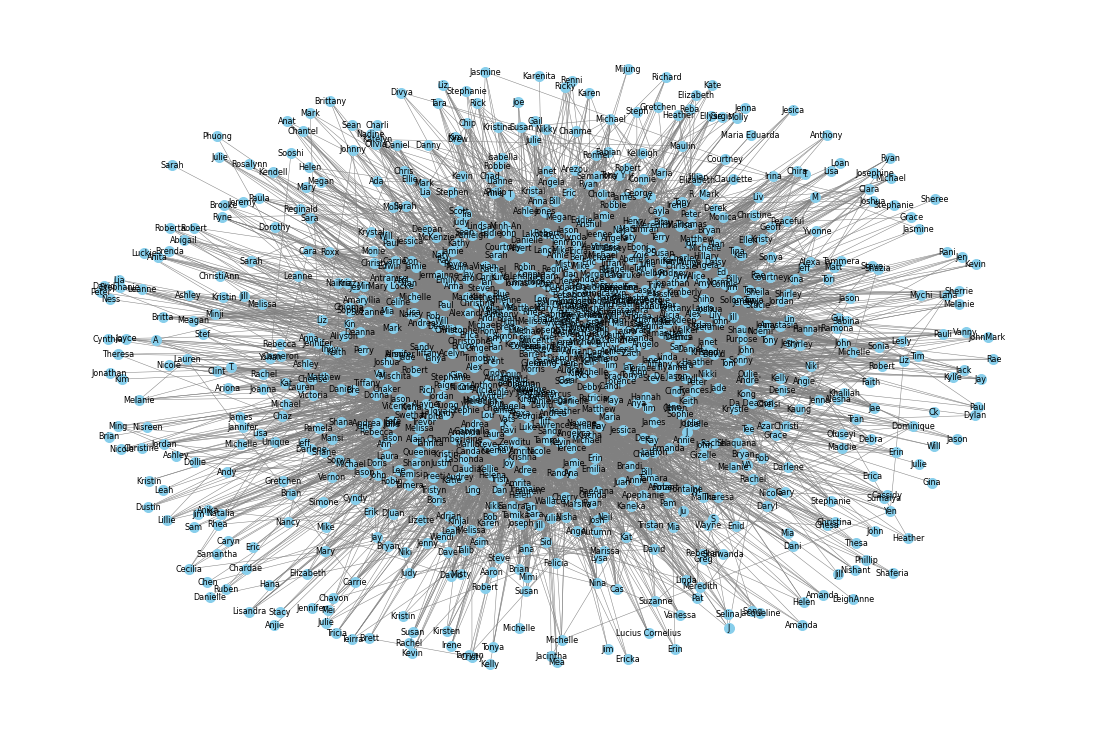

In [20]:
# Create a graph
G = nx.Graph()

# Add nodes and label them with the user's name
for user_id, name in zip(sample_users['user_id'], sample_users['name']):
    G.add_node(user_id, label=name)

# Add edges
for user_id, friends in zip(sample_users['user_id'], sample_users['friends']):
    for friend in friends:
        G.add_edge(user_id, friend)

# Get the node labels
node_labels = nx.get_node_attributes(G, 'label')

# Compute the node positions using the spring layout algorithm
pos = nx.spring_layout(G, k=0.5)

# Create a larger figure
plt.figure(figsize=(10, 10))

# Plot the graph
nx.draw(G, pos=pos, labels=node_labels, with_labels=True, node_size=100, node_color='skyblue', edge_color='grey', width=0.5, font_size=8)
plt.show()

In [14]:
# Compute the degree centrality of each node
degree_centrality = nx.degree_centrality(G)

# Compute the betweenness centrality of each node
betweenness_centrality = nx.betweenness_centrality(G)

# Compute the closeness centrality of each node
closeness_centrality = nx.closeness_centrality(G)

# Print the results
print('Degree Centrality:', degree_centrality)
print('Betweenness Centrality:', betweenness_centrality)
print('Closeness Centrality:', closeness_centrality)

Degree Centrality: {'qVc8ODYU5SZjKXVBgXdI7w': 0.03003003003003003, 'j14WgRoU_-2ZE1aw1dXrJg': 0.998998998998999, 'QJI9OSEn6ujRCtrX06vs1w': 0.14414414414414414, '2l0O1EI1m0yWjFo2zSt71w': 0.06706706706706707, 'V6PeLHJ8D1C7utl4HzjBmg': 0.058058058058058054, 'VHdY6oG2JPVNjihWhOooAQ': 0.0920920920920921, 'om5ZiponkpRqUNa3pVPiRg': 0.16916916916916916, '0G-QF457q_0Z_jKqh6xWiA': 0.2222222222222222, 'AW0tVcfwYZBiwtwYyaX0WA': 0.02002002002002002, 'Z4rItwH8eQyhqkfGi9_6qg': 0.015015015015015015, 'v9VCObZVWhOPdm1rKt8Dvg': 0.057057057057057055, 'gjhzKWsqCIrpEd9pevbKZw': 0.14814814814814814, 'ci7Q6NvXQ8UZrBHusVX18g': 0.11411411411411411, 'rgHK4_IdibIrF990TTRoIQ': 0.02002002002002002, 'qRBTAUOEWrBY9N1JszH1ow': 0.02702702702702703, 'tipQmXdg181T4NvxrXPjFg': 0.08408408408408408, 'OgYi5x02MBukfxPNFe1ePg': 0.08608608608608609, '4VbB9qS2Xvk-bjAI1bNlGw': 0.08408408408408408, 'lf1m4CbheuUR7fFZoLGRvA': 0.08408408408408408, '0MeivhX0kZCfV3zMtHtk9Q': 0.04504504504504504, 'pTUlF0nvcUOEbg8E_8QWxg': 0.0330330330330

In [15]:
# get the reviews of the users in the sample
sample_reviews = reviews[reviews['user_id'].isin(sample_users['user_id'])]

sample_reviews.head()
sample_reviews.shape

(55016, 9)

In [18]:
# get the businesses from the sample reviews
sample_business = business[business['business_id'].isin(sample_reviews['business_id'])]

sample_business.head()
sample_business.shape

(27685, 14)

In [19]:
# save user samples to pickle
save_file('./data/sample_users.pickle', sample_users)

# save user reviews to pickle
save_file('./data/sample_reviews.pickle', sample_reviews)

# save user businesses to pickle
save_file('./data/sample_business.pickle', sample_business)

In [5]:
# load user samples from pickle
loaded_users_sample = read_file('./data/sample_users.pickle')

# load user reviews from pickle
loaded_reviews_sample = read_file('./data/sample_reviews.pickle')

# load user businesses from pickle
loaded_business_sample = read_file('./data/sample_business.pickle')

In [6]:
sample_business = loaded_business_sample
sample_reviews = loaded_reviews_sample
sample_users = loaded_users_sample

## Data Exploration

### Data Cleaning

In [7]:
sample_users.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"[om5ZiponkpRqUNa3pVPiRg, 4OH-U9PWeBa9HOPM4f3-z...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","[BW_Lpb14P7CTQwHlaek0_w, 1_cezAbuZSyLR1-FL6V91...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
38,QJI9OSEn6ujRCtrX06vs1w,J,1982,2007-03-19 18:15:32,14004,6466,9879,2010,"[ya3mbvTaymecfrTc08SxhQ, CNdJaOdUjLIceVxhWcMNR...",316,...,98,156,52,68,786,3674,2093,2093,562,1509
55,2l0O1EI1m0yWjFo2zSt71w,Shiho,2837,2005-07-02 01:59:55,19237,9542,15235,"2006,2007,2008,2009,2010,2011","[9GhiQOLaM6ZGrrFG-SppwQ, d67zTET_2IuVoWcUU0aWa...",492,...,108,85,79,40,350,742,1070,1070,403,258
57,V6PeLHJ8D1C7utl4HzjBmg,Jay,371,2010-01-26 21:04:52,2933,1129,1861,"2012,2013,2014,2015,2016,2017","[-IgKkE8JvYNWeGu8ze4P8Q, 9w32ooe10bil7oIr5ycQA...",112,...,14,45,0,3,157,432,535,535,198,74


In [10]:
sample_reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
174,RdeS7gqrmVs5kJtazzVr3A,_cdKam8UxhoPni6YwP1LQw,J55AT36H5EeJ9ey8etGjHA,5,14,6,9,This small little donut bakery is located in o...,2014-01-17 05:36:14
216,g7MfpJGKQUGowCvIcrB91A,ci7Q6NvXQ8UZrBHusVX18g,V6Om7YZhlRQRU7WfuxHq8Q,4,1,0,0,A wee bit pricey for the portions they serve. ...,2017-07-08 21:23:54
265,GY2rCySJI41AXWMXvrDTJg,nnImk681KaRqUVHlSfZjGQ,nFjk0xVI9fNiVN__5g-m8Q,5,4,2,6,Ichicoro Ane gets lots of things right and the...,2018-02-23 22:49:01
381,MWUGmzyXVIlG2NwvzX0q4Q,Xw7ZjaGfr0WNVt6s_5KZfA,i-tDq8zC7ZmSqSbg_7oddA,5,11,5,8,What an AMAZING occurrence that we ended up he...,2016-11-21 20:04:45
605,7Ki1tkHP23P2i--9qsTRdg,-G7Zkl1wIWBBmD0KRy_sCw,IbndcMURguByburM72o3SA,5,9,6,4,"Just finished a State Street Kitchen, Grilled ...",2013-10-24 18:13:21


In [8]:
sample_business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
10,UJsufbvfyfONHeWdvAHKjA,Marshalls,21705 Village Lakes Sc Dr,Land O' Lakes,FL,34639,28.190459,-82.457380,3.5,6,1,"{'RestaurantsPriceRange2': '2', 'BikeParking':...","Department Stores, Shopping, Fashion","{'Monday': '9:30-21:30', 'Tuesday': '9:30-21:3..."
11,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,"{'Alcohol': ''none'', 'OutdoorSeating': 'None'...","Vietnamese, Food, Restaurants, Food Trucks","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'..."
15,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,1,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-..."


In [9]:
# Check for duplicates
print('Number of duplicates:', sample_users.duplicated(subset=['user_id']).sum())
print('Number of duplicates:', sample_reviews.duplicated(subset=['review_id']).sum())
print('Number of duplicates:', sample_business.duplicated(subset=['business_id']).sum())


Number of duplicates: 0
Number of duplicates: 0
Number of duplicates: 0


In [10]:
# Check for missing values
sample_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 399358
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             1000 non-null   object 
 1   name                1000 non-null   object 
 2   review_count        1000 non-null   int64  
 3   yelping_since       1000 non-null   object 
 4   useful              1000 non-null   int64  
 5   funny               1000 non-null   int64  
 6   cool                1000 non-null   int64  
 7   elite               912 non-null    object 
 8   friends             1000 non-null   object 
 9   fans                1000 non-null   int64  
 10  average_stars       1000 non-null   float64
 11  compliment_hot      1000 non-null   int64  
 12  compliment_more     1000 non-null   int64  
 13  compliment_profile  1000 non-null   int64  
 14  compliment_cute     1000 non-null   int64  
 15  compliment_list     1000 non-null   int64  
 16  comp

In [14]:
# Check for missing values
sample_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55016 entries, 174 to 6990279
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   review_id    55016 non-null  object        
 1   user_id      55016 non-null  object        
 2   business_id  55016 non-null  object        
 3   stars        55016 non-null  int64         
 4   useful       55016 non-null  int64         
 5   funny        55016 non-null  int64         
 6   cool         55016 non-null  int64         
 7   text         55016 non-null  object        
 8   date         55016 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 4.2+ MB


In [11]:
# Check for missing values
sample_business.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27685 entries, 2 to 150343
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   27685 non-null  object 
 1   name          27685 non-null  object 
 2   address       27685 non-null  object 
 3   city          27685 non-null  object 
 4   state         27685 non-null  object 
 5   postal_code   27685 non-null  object 
 6   latitude      27685 non-null  float64
 7   longitude     27685 non-null  float64
 8   stars         27685 non-null  float64
 9   review_count  27685 non-null  int64  
 10  is_open       27685 non-null  int64  
 11  attributes    26737 non-null  object 
 12  categories    27685 non-null  object 
 13  hours         24505 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 3.2+ MB


### Data Visualization

In [12]:
# mean of the stars of the reviews of the sample
sample_reviews['stars'].mean()

3.9685182492365856

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# preprocess the text data
categories = sample_business['categories'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True)

# vectorize the text data
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(categories)

# cluster the data
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

# convert the categories Series into a DataFrame
categories = categories.to_frame(name='category')

# assign the cluster labels to the categories
categories['cluster'] = kmeans.labels_

/home/carlosmgomes/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


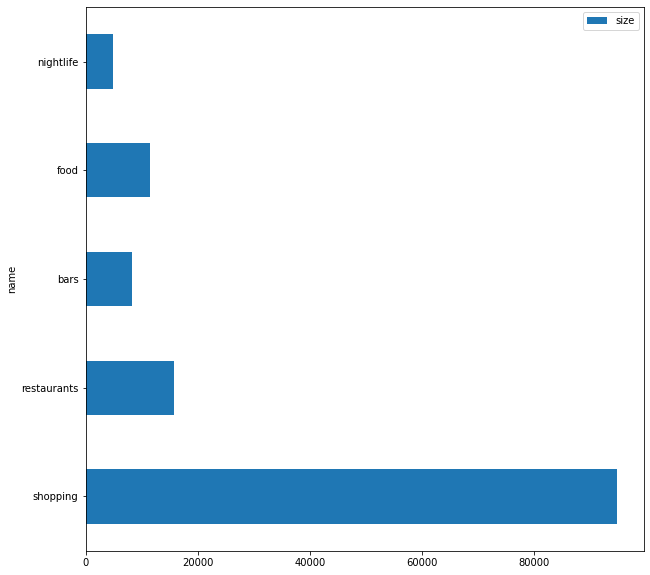

In [14]:
from sklearn.decomposition import LatentDirichletAllocation

# group the categories by their cluster labels
clustered_categories = categories.groupby('cluster')

# create a list to store the general category names
cluster_names = []

# iterate over each cluster
for cluster, group in clustered_categories:
    # vectorize the text data in the cluster
    X = vectorizer.transform(group['category'])
    
    # fit an LDA model to the data
    lda = LatentDirichletAllocation(n_components=1)
    lda.fit(X)
    
    # get the most representative word for the cluster
    words = vectorizer.get_feature_names()
    topic_word = words[np.argmax(lda.components_[0])]
    
    # add the general category name to the list
    cluster_names.append(topic_word)

# create a new DataFrame with the cluster sizes and general category names
cluster_sizes = clustered_categories.size().reset_index(name='size')
cluster_sizes['name'] = cluster_names

# plot the distribution of clusters using the general category names
cluster_sizes.plot(x='name', y='size', kind='barh', figsize=(10, 10))
plt.show()

## Social Network Analysis

Create a bipartite graph to analyze the relationships between users and businesses to understand how users influence each other’s opinions and decisions.

In [15]:
# Create an empty bipartite graph
B = nx.Graph()

# Add nodes for users and businesses
B.add_nodes_from(sample_users['user_id'], bipartite=0)
B.add_nodes_from(sample_business['business_id'], bipartite=1)

# Add edges between users and businesses based on interactions such as reviews or ratings
for index, row in sample_reviews.iterrows():
    B.add_edge(row['user_id'], row['business_id'])

In [ ]:
# print number of nodes and edges in the graph
print('Number of nodes:', B.number_of_nodes())
print('Number of edges:', B.number_of_edges())

Calculate centrality measures

In [16]:
degree_centrality = nx.degree_centrality(B)
closeness_centrality = nx.closeness_centrality(B)
betweenness_centrality = nx.betweenness_centrality(B)
eigenvector_centrality = nx.eigenvector_centrality(B)

KeyboardInterrupt: 

In [13]:
# Calculate degree centrality (no approximation or parallelization needed)
degree_centrality = nx.degree_centrality(B)

# Calculate closeness centrality using an approximation algorithm
from networkx.algorithms.approximation import closeness_centrality
closeness_centrality = closeness_centrality(B)

# Calculate betweenness centrality using an approximation algorithm and parallel processing
from networkx.algorithms.approximation import betweenness_centrality
from multiprocessing import Pool
p = Pool()
betweenness_centrality = betweenness_centrality(B, processes=p)

# Calculate eigenvector centrality using parallel processing
from networkx.algorithms.centrality import eigenvector_centrality_parallel
eigenvector_centrality = eigenvector_centrality_parallel(B)

ImportError: cannot import name 'closeness_centrality' from 'networkx.algorithms.approximation' (/home/carlosmgomes/.local/lib/python3.10/site-packages/networkx/algorithms/approximation/__init__.py)

Visualization

In [ ]:
plt.figure()
plt.hist(list(degree_centrality.values()))
plt.title('Degree Centrality')
plt.show()

plt.figure()
plt.hist(list(closeness_centrality.values()))
plt.title('Closeness Centrality')
plt.show()

plt.figure()
plt.hist(list(betweenness_centrality.values()))
plt.title('Betweenness Centrality')
plt.show()

plt.figure()
plt.hist(list(eigenvector_centrality.values()))
plt.title('Eigenvector Centrality')
plt.show()

Perform link analysis using the HITS algorithm

In [ ]:
hubs, authorities = nx.hits(B)

Visualization

In [ ]:
plt.figure()
plt.hist(list(hubs.values()))
plt.title('Hubs')
plt.show()

plt.figure()
plt.hist(list(authorities.values()))
plt.title('Authorities')
plt.show()

Detect communities using the Louvain method

In [ ]:
# Detect communities using the Louvain method
partition = best_partition(B)

Visualization

In [ ]:
communities = Counter(partition.values())
communities = sorted(communities.items(), key=lambda x: x[1], reverse=True)

labels, values = zip(*communities)
indexes = range(len(labels))
width = 1

plt.figure()
plt.bar(indexes, values, width)
plt.xticks(indexes, labels)
plt.title('Communities')
plt.show()

explanation:
Centrality measures: The centrality scores can help you identify the most important or influential nodes in the graph. For example, nodes with high degree centrality have many connections to other nodes, while nodes with high closeness centrality are close to many other nodes in the graph. Nodes with high betweenness centrality lie on many shortest paths between other nodes, while nodes with high eigenvector centrality are connected to many other nodes that are themselves well-connected.

Link analysis: The hub and authority scores from the HITS algorithm can help you identify hubs and authorities within the network. Hubs are nodes that link to many other nodes, while authorities are nodes that are linked to by many other nodes. In the context of your Yelp dataset, hubs could represent users who have reviewed many businesses, while authorities could represent businesses that have been reviewed by many users.

Community detection: The community assignments from the Louvain method can help you identify groups of nodes that are more densely connected to each other than to the rest of the network. In the context of your Yelp dataset, communities could represent groups of users who have similar interaction patterns with businesses.